#Report


## **Semi-Supervised Learning (Fashion MNIST Dataset)**
### **Abhishek Mishra (MDS202101), Dhruvee Chauhan (MDS202115)**

**Introduction**

Clustering is usually used for problems related to unsupervised learning but we will use it as a pre-processing tool for semi-supervised learning. If we only have a few labels, we could perform clustering and propagate the labels to all the instances in the same cluster. Since it is tedious to label each instance clustering helps reduce the manual work involved in labelling, cutting down only to centroids. This technique can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.

Let us see how this idea of semi-supervised learning works on the dataset.

**About the Dataset**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples, test set of 10,000 examples.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels (see above), and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

**Methodology**

We performed the semi-supervised learning by applying KMeans Clustering to label the data and then perform Logistic Regression on it.

We first loaded the data and flatten it to 1D so we can operate logistic regression. On operating logistic regression on unlabelled data we get accuracy of `0.841`. 

For KMeans Clustering we used the elbow method to conclude that the optimal `k = 1000`. Following which we used `pipeline` from SKlearn to perform KMeans Clustering and Logistic Regression on the data. The labels used for classification are based on the cluster centriods obtained from clustering. We did this for `k = 300, 500, 1000`. The accuracy increases as the number of clusters are increased. 

We calculated `1000` centroids and applied logistic regression on it. We then did the clustering for first `1000` data points and labelled them and applied Logistic Regression on it. The accuracy obtained in this case is `0.871`.

After obtaining 1000 centroids as optimal, we consider propagating labels to the entire dataset & then to some closest data points, say 20% of the closest data points. This is done for radii 0.1 to 0.8. The accuracies are added in the table below as `part_pro_radius`. As the radius increases, the accuracy improves. 

The Accuracy of all the methods applied are:

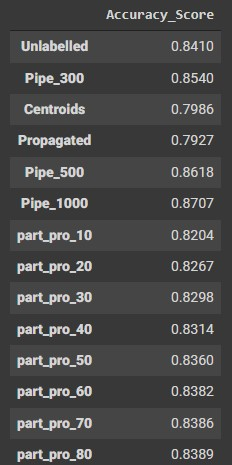

#Loading Packages

In [ ]:
!pip install memory-profiler
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, metrics, callbacks, datasets
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from joblib import dump, load
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed=42
tf.random.set_seed(seed)
%load_ext memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=ff186240917d0d1c169b13c19e2642ce7b10b247344852254a08d1c356d85d01
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


#Loading the Data

In [ ]:
%%time
%%memit
(train_img, train_y),(test_img, test_y) = datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

4431872/4422102 [==============================] - 0s 0us/step
peak memory: 634.09 MiB, increment: 105.53 MiB
CPU times: user 750 ms, sys: 207 ms, total: 957 ms
Wall time: 1.16 s


In [ ]:
%%time
%%memit
#Normalizing the train and test data
train_img, test_img = train_img/255.0, test_img/255.0

peak memory: 1053.48 MiB, increment: 419.38 MiB
CPU times: user 249 ms, sys: 149 ms, total: 398 ms
Wall time: 506 ms


In [ ]:
%%time
%%memit
#Converting the data into 1D array
train_img_1D = train_img.reshape(train_img.shape[0],-1)
train_y_1D = train_y.reshape(train_y.shape[0],-1)
test_img_1D = test_img.reshape(test_img.shape[0],-1)
test_y_1D = test_y.reshape(test_y.shape[0],-1)

peak memory: 1053.57 MiB, increment: 0.02 MiB
CPU times: user 159 ms, sys: 69.9 ms, total: 229 ms
Wall time: 392 ms


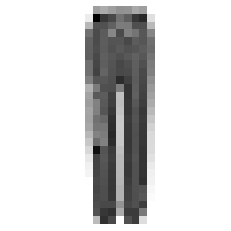

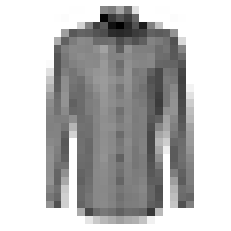

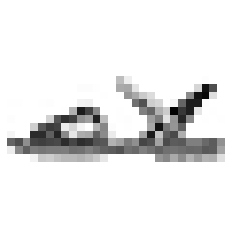

peak memory: 1057.24 MiB, increment: 3.61 MiB
CPU times: user 317 ms, sys: 50.9 ms, total: 368 ms
Wall time: 495 ms


In [ ]:
%%time
%%memit
#Visualizinng few data points
index = [1000, 3000, 35000]
for i in index:
  plt.imshow(train_img[i], cmap = 'binary')
  plt.axis('off')
  plt.show()

#Logistic Regression

##On Unlabelled Data

In [ ]:
%%time
%%memit
log_reg = LogisticRegression(multi_class="ovr", solver="newton-cg", max_iter=5000, random_state=seed)

peak memory: 2044.21 MiB, increment: 0.00 MiB
CPU times: user 159 ms, sys: 88.8 ms, total: 248 ms
Wall time: 410 ms


In [ ]:
log_reg.fit(train_img_1D, train_y_1D.ravel())
dump(log_reg,'log_reg_propagated.joblib')
print(log_reg.score(test_img_1D,test_y_1D))

0.841


##Finding Optimal K for clustering

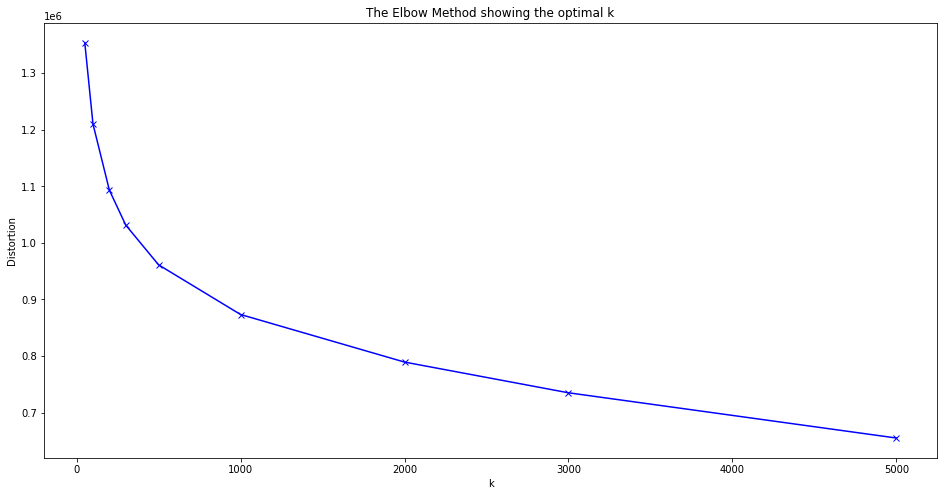

peak memory: 3648.35 MiB, increment: 1.40 MiB
CPU times: user 343 ms, sys: 72 ms, total: 415 ms
Wall time: 548 ms


In [ ]:
%%time 
%%memit #took nearly 5 hours
distortion = []
K = [50, 100, 200, 300, 500, 1000, 2000, 3000, 5000]
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(train_img_1D)
    distortion.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

##Pipeline

In [ ]:
%%time
%%memit
k = [300, 500, 1000]
Acc = []
pipe = np.empty(len(k),dtype = object)
for i in range(len(k)):
    pipe[i] = Pipeline([("kmeans", KMeans(init ='k-means++',n_clusters = k[i], random_state=seed)),
                         ("log_reg", log_reg)])
    pipe[i].fit(train_img_1D, train_y_1D.ravel())
    dump(pipe[i],'log_reg_kmeans_{}.joblib'.format(i))
    Acc.append(pipe[i].score(test_img_1D,test_y_1D))
    print('Cluster= {}, Accuracy= {}'.format(k[i],
            pipe[i].score(test_img_1D,test_y_1D)))
    

Cluster= 300, Accuracy= 0.854
Cluster= 500, Accuracy= 0.8618
Cluster= 1000, Accuracy= 0.8707
peak memory: 2506.39 MiB, increment: 230.32 MiB
CPU times: user 12h 47min 13s, sys: 25min 37s, total: 13h 12min 51s
Wall time: 6h 51min 45s


##Finding Centroids

In [ ]:
%%time
%%memit
kmeans_1000 = KMeans(init = 'k-means++',n_clusters = 1000, random_state = seed)
img_dist = kmeans_1000.fit_transform(train_img_1D) #stores distances of each data points
dump(kmeans_1000,'kmeans_1000.joblib')
rep_items_idx = np.argmin(img_dist, axis=0) #return index of min element per column
rep_items_x = train_img_1D[rep_items_idx] #collects X from the flatten dataset repective to the above indices
rep_items_y = np.squeeze(train_y_1D[rep_items_idx]).astype('int32') #gets the corresponfing Y to the corresponding X (clusters)

peak memory: 2043.64 MiB, increment: 986.33 MiB
CPU times: user 53min 59s, sys: 1min 50s, total: 55min 50s
Wall time: 29min 38s


##Fitting Centroids in Logistic Regression

In [ ]:
%%time
%%memit
log_reg.fit(rep_items_x, rep_items_y)
dump(log_reg,'log_reg_centroids.joblib')
print('Accuracy= ',log_reg.score(test_img_1D, test_y_1D))

Accuracy=  0.7986
peak memory: 2304.80 MiB, increment: 0.01 MiB
CPU times: user 2.69 s, sys: 1.31 s, total: 4 s
Wall time: 2.24 s


##Propagating Labels

In [ ]:
%%time
%%memit
train_y_spread = np.empty(len(train_img_1D), dtype=np.int32)
for i in range(1000):
    train_y_spread[kmeans_1000.labels_==i] = rep_items_y[i]

peak memory: 2304.79 MiB, increment: -0.01 MiB
CPU times: user 228 ms, sys: 112 ms, total: 340 ms
Wall time: 386 ms


In [ ]:
%%time
%%memit
log_reg.fit(train_img_1D, train_y_spread)
dump(log_reg,'log_reg_propagated.joblib')
print(log_reg.score(test_img_1D,test_y_1D))

0.7927
peak memory: 2304.89 MiB, increment: 0.07 MiB
CPU times: user 12min 35s, sys: 55.5 s, total: 13min 31s
Wall time: 7min 4s


##Partially Propagating

In [ ]:
%%time
%%memit
per = [10, 20, 30, 40, 50, 60, 70, 80]
scores = []
for j in per:
  img_c_dist = img_dist[np.arange(len(train_img_1D)), kmeans_1000.labels_]
  for i in range(1000):
    in_cluster = (kmeans_1000.labels_ == i)
    cluster_dist = img_c_dist[in_cluster]
    threshold = np.percentile(cluster_dist, j)
    a_threshold = (img_c_dist > threshold)
    img_c_dist[in_cluster & a_threshold] = -1
  part_spread = (img_c_dist != -1)
  X_train_part_spread = train_img_1D[part_spread]
  y_train_part_spread = train_y_1D[part_spread]
  log_reg.fit(X_train_part_spread, y_train_part_spread)
  dump(log_reg,'log_reg_partially_propagated.joblib')
  scores.append(log_reg.score(test_img_1D,test_y_1D))


peak memory: 2807.07 MiB, increment: 502.18 MiB
CPU times: user 34min 29s, sys: 3min 51s, total: 38min 20s
Wall time: 19min 45s


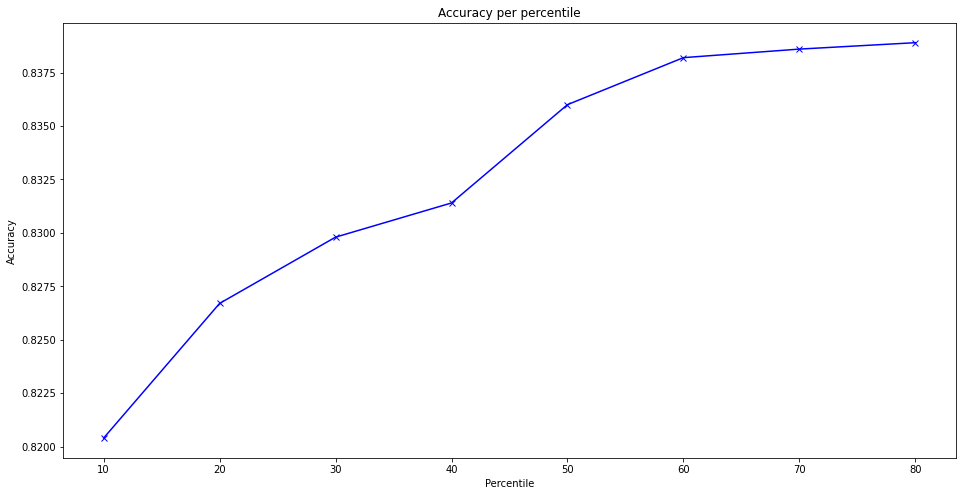

peak memory: 2807.82 MiB, increment: 0.75 MiB
CPU times: user 386 ms, sys: 121 ms, total: 507 ms
Wall time: 546 ms


In [ ]:
%%time
%%memit
plt.figure(figsize=(16,8))
plt.plot(per, scores, 'bx-')
plt.xlabel('Percentile')
plt.ylabel('Accuracy')
plt.title('Accuracy per percentile')
plt.show()